### Installs and imports

In [1]:
pip install imblearn

In [2]:
pip install lightgbm

In [3]:
import numpy as np
import pandas as pd

import functools
import sklearn.metrics as metrics
import sklearn
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

# Configure Kaggle API (guide [here](https://www.kaggle.com/general/74235))

In [4]:
pip install kaggle

In [5]:
from google.colab import files
# select your kaggle.json file from your computer
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danylokiral","key":"04153e52fa474a0ffe4403c094f1f3b2"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download data from Kaggle

In [7]:
! kaggle competitions download -c ieee-fraud-detection

  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 78.4MB/s]
 94% 49.0M/52.2M [00:01<00:00, 32.2MB/s]
100% 52.2M/52.2M [00:01<00:00, 37.3MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 107MB/s]
 70% 41.0M/58.3M [00:01<00:00, 27.4MB/s]
100% 58.3M/58.3M [00:01<00:00, 39.0MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]


In [8]:
! mkdir data
! unzip train_transaction.csv.zip -d data
! unzip train_identity.csv.zip -d data
! unzip test_transaction.csv.zip -d data
! unzip test_identity.csv.zip -d data

Archive:  train_transaction.csv.zip
  inflating: data/train_transaction.csv  
Archive:  train_identity.csv.zip
  inflating: data/train_identity.csv  
Archive:  test_transaction.csv.zip
  inflating: data/test_transaction.csv  
Archive:  test_identity.csv.zip
  inflating: data/test_identity.csv  


In [9]:
! rm train_transaction.csv.zip
! rm train_identity.csv.zip
! rm test_transaction.csv.zip
! rm test_identity.csv.zip

# Load data

In [10]:
train_transactions = pd.read_csv('data/train_transaction.csv')
train_identities = pd.read_csv('data/train_identity.csv')
data = train_transactions.merge(train_identities, how='left', left_index=True, right_index=True)

In [11]:
data.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [12]:
data.describe()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionID_y,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+0

In [13]:
data.shape

(590540, 435)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID_x to DeviceInfo
dtypes: float64(400), int64(4), object(31)
memory usage: 1.9+ GB


# EDA

### Helper functions

In [15]:
def countplot_viz(data,xcolumn,xlabel,ylabel,title,hue=None,fontsize_label=16,fontsize_title=20,fontsize_text=12,rotation=45,figsize_x=12,figsize_y=5,palette="mako",):
    plt.figure(figsize=(figsize_x,figsize_y))
    g = sns.countplot(x=xcolumn, data=data, hue=hue, palette=palette)
    g.set_title(title, fontsize=19)
    g.set_xlabel(xlabel, fontsize=17)
    g.set_ylabel(ylabel, fontsize=17)
    g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    for p in g.patches:
        height = p.get_height()
        g.text(
            p.get_x() + p.get_width() / 2.0,
            height + 3,
            "{:1}".format(height),
            ha="center",
            fontsize=fontsize_text,
        )    
    if hue != None:
        g.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0) 

def countplot_pointplot_viz(data,filter_list,xcolumn,ycolumn,ycolumn_point,xlabel,ylabel,title,hue=None,fontsize_label=16,fontsize_title=20,fontsize_text=12,rotation=45,figsize_x=12,figsize_y=5,palette="mako",):

    plt.figure(figsize=(figsize_x,figsize_y)) 
    
    filter_list = filter_list
    df2 = data[data[ycolumn].isin(filter_list)]
    order = df2[xcolumn].value_counts().index

    ax1 = sns.countplot(
        x=xcolumn, hue=ycolumn, data=df2, hue_order=filter_list, palette=palette
    )
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(
            p.get_x() + p.get_width() / 2.0,
            height + 3,
            "{:1}".format(height),
            ha="center",
            fontsize=fontsize_text,
        )
    ax1.set_title(title, fontsize=19)
    ax1.set_xlabel(xlabel, fontsize=17)
    ax1.set_ylabel(ylabel, fontsize=17)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    
    ax2 = ax1.twinx()
    sns.pointplot(x=xcolumn, y=ycolumn_point, data=df2, ax=ax2)

def boxplot_viz(data,xcolumn,xlabel,title,hue=None,fontsize_label=16,fontsize_title=20,rotation=45,palette="mako",):
    plt.figure(1, figsize=(9, 6))

    sns.boxplot(x=xcolumn, data=data, hue=hue, palette=palette)
    plt.xlabel(xlabel, fontsize=fontsize_label) 
    plt.title(title, fontsize=fontsize_title)
    plt.xticks(rotation=rotation)
    plt.show()


def histogram_multiple_viz(data,column,separate_column,condition_1,condition_2,title1,title2,title3,title4,color1="blue",color2="darkorange",):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
    data.loc[data[separate_column] == condition_1][column].apply(
        np.log
    ).plot(
        kind="hist",
        bins=100,
        title=title1,
        color=color1,
        xlim=(-3, 10),
        ax=ax1,
    )
    data.loc[data[separate_column] == condition_2][column].apply(
        np.log
    ).plot(
        kind="hist",
        bins=100,
        title=title2,
        color=color2,
        xlim=(-3, 10),
        ax=ax2,
    )
    data.loc[data[separate_column] == condition_1][column].plot(
        kind="hist", bins=100, title=title3, color=color1, ax=ax3
    )
    data.loc[data[separate_column] == condition_2][column].plot(
        kind="hist",
        bins=100,
        title=title4,
        color=color2,
        ax=ax4,
    )
    plt.show()     

### Analysis

In [16]:
data.describe()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionID_y,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+0

In [17]:
data.shape

(590540, 435)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID_x to DeviceInfo
dtypes: float64(400), int64(4), object(31)
memory usage: 1.9+ GB


In [19]:
data.columns.values

array(['TransactionID_x', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', '

In [20]:
data.dtypes.value_counts()

float64    400
object      31
int64        4
dtype: int64

In [21]:
data['isFraud'].value_counts(normalize=True)*100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

We see great class imbalance which will be solved while fitting our set by 
choosing sample strategy

In [22]:
not_nan = data.isna().sum()
not_nan[not_nan==0]

TransactionID_x    0
isFraud            0
TransactionDT      0
TransactionAmt     0
ProductCD          0
card1              0
C1                 0
C2                 0
C3                 0
C4                 0
C5                 0
C6                 0
C7                 0
C8                 0
C9                 0
C10                0
C11                0
C12                0
C13                0
C14                0
dtype: int64

Only 20 columns out of 433 do not contain missing value

In [23]:
nans_df = pd.DataFrame({
    'feature': data.columns, 
    'nan_number': [(data[col].isna().sum())/data.shape[0]*100 for col in data.columns]
})
nans_df.sort_values(by=['nan_number'], ascending=False, inplace=True)

In [24]:
nans_df[nans_df['nan_number']>80]

,feature,nan_number
418,id_24,99.196159
419,id_25,99.130965
401,id_07,99.127070
402,id_08,99.127070
415,id_21,99.126393
...,...,...
381,V327,86.054967
380,V326,86.054967
376,V322,86.054967
377,V323,86.054967


In [25]:
train_corrs = data.corr()
train_corrs.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,TransactionID_y,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
TransactionID_x,1.000000,0.014166,0.998280,0.012025,0.010122,-0.019900,-0.010091,-0.023900,-0.000370,0.057213,-0.027043,-0.026273,-0.053154,-0.055186,-0.008896,-0.057235,0.024444,-0.050376,-0.059485,-0.060490,0.033460,-0.062073,-0.054122,-0.058796,-0.017455,-0.043123,0.074338,0.026477,-0.006997,0.058633,0.002053,0.081941,-0.071569,-0.071505,-0.015457,0.056533,0.100242,0.052536,0.023352,0.095742,...,0.227296,0.089691,0.251746,0.242576,0.240570,0.244867,0.250831,0.199285,0.219190,0.223816,0.005893,0.179740,0.103030,0.074034,0.203922,0.162702,0.983442,-0.097969,0.176507,-0.027405,0.000938,-0.060174,-0.028704,-0.103939,0.040510,-0.034161,0.010646,0.034738,0.071519,0.040797,0.239735,0.115378,-0.022907,0.088561,-0.045001,0.052699,-0.057259,0.020670,0.001818,-0.049421
isFraud,0.014166,1.000000,0.013103,0.011320,-0.013640,0.003388,0.154151,-0.033580,0.005596,-0.030387,0.021522,-0.019054,0.030570,0.037229,-0.006833,0.030382,-0.030754,0.020909,0.028160,0.032139,-0.031703,0.028396,0.027484,0.031905,-0.011146,0.007921,-0.067193,-0.083583,-0.046271,-0.067216,-0.064638,-0.057236,-0.127199,-0.142636,-0.044253,-0.072002,-0.045094,-0.028864,-0.059430,-0.008663,...,-0.024006,0.007792,-0.006838,-0.001050,-0.011053,-0.023099,-0.021164,-0.021982,-0.023468,-0.024134,-0.000451,-0.005456,-0.002402,-0.005702,-0.019356,-0.014663,0.007155,0.001209,-0.006195,-0.003787,-0.004950,0.002141,0.001541,-0.010620,-0.004329,-0.001365,0.001460,0.002298,0.002908,0.000666,-0.003713,-0.009040,0.000840,-0.001578,0.038820,0.020338,0.009990,-0.000063,0.012422,-0.000147
TransactionDT,0.998280,0.013103,1.000000,0.011920,0.010625,-0.019202,-0.011222,-0.024132,-0.000051,0.051972,-0.027295,-0.026860,-0.049318,-0.051126,-0.007546,-0.053104,0.023800,-0.046612,-0.055402,-0.056288,0.032732,-0.057734,-0.050181,-0.054738,-0.015022,-0.039721,0.074031,0.027109,-0.007200,0.059797,0.001767,0.084581,-0.070221,-0.068752,-0.013735,0.058409,0.101266,0.053108,0.024405,0.097509,...,0.234674,0.091039,0.257295,0.248494,0.247530,0.252599,0.258603,0.205671,0.226312,0.231072,0.005762,0.184407,0.105783,0.075892,0.210240,0.167524,0.970299,-0.098281,0.173201,-0.028124,0.001934,-0.059251,-0.028799,-0.097153,0.040090,-0.033789,0.011594,0.035844,0.056941,0.040173,0.238472,0.116359,-0.022703,0.088085,-0.051960,0.050779,-0.059103,0.019173,0.000234,-0.043392
TransactionAmt,0.012025,0.011320,0.011920,1.000000,-0.005725,0.016136,-0.109785,0.003061,-0.007421,0.028312,0.026146,0.023143,-0.017722,-0.018468,-0.004798,-0.010148,-0.030560,-0.016982,-0.017061,-0.014820,-0.030021,-0.015958,-0.017313,-0.017135,-0.040034,-0.022435,-0.039985,-0.003760,-0.002166,-0.050347,-0.001490,0.057674,0.099719,0.096806,0.073852,-0.038982,-0.088448,-0.065834,0.041298,0.072110,...,-0.009281,0.018288,-0.069407,-0.046455,0.038277,-0.004608,0.003909,0.024319,0.010808,0.017385,0.078751,0.044830,0.070651,0.129452,0.082064,0.105996,-0.008580,-0.005494,-0.001574,-0.002021,-0.006216,-0.000897,-0.001073,0.005328,0.004403,-0.000398,0.001306,0.002972,-0.008196,-0.001450,-0.003025,0.004291,0.003220,-0.002855,-0.017997,0.007569,-0.021137,0.001941,0.015339,0.003675
card1,0.010122,-0.013640,0.010625,-0.005725,1.000000,0.004960,0.002965,-0.093633,0.020369,-0.000060,0.005152,-0.003749,0.005716,0.005199,-0.004710,0.005193,0.005752,0.006575,0.004641,0.004645,0.004370,0.003794,0.005808,0.004210,0.004300,0.007366,-0.006619,-0.012949,-0.005352,-0.002721,-0.003120,-0.002899,-0.022303,-0.040851,-0.000275,-0.000844,-0.005144,-0.020610,-0.028603,0.034955,...,0.138616,0.031315,0.079462,0.098211,0.134419,0.142539,0.146483,0.121763,0

In [26]:
top_corr = train_corrs['isFraud'].abs().sort_values(ascending=False)[:10]
top_corr

isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
Name: isFraud, dtype: float64

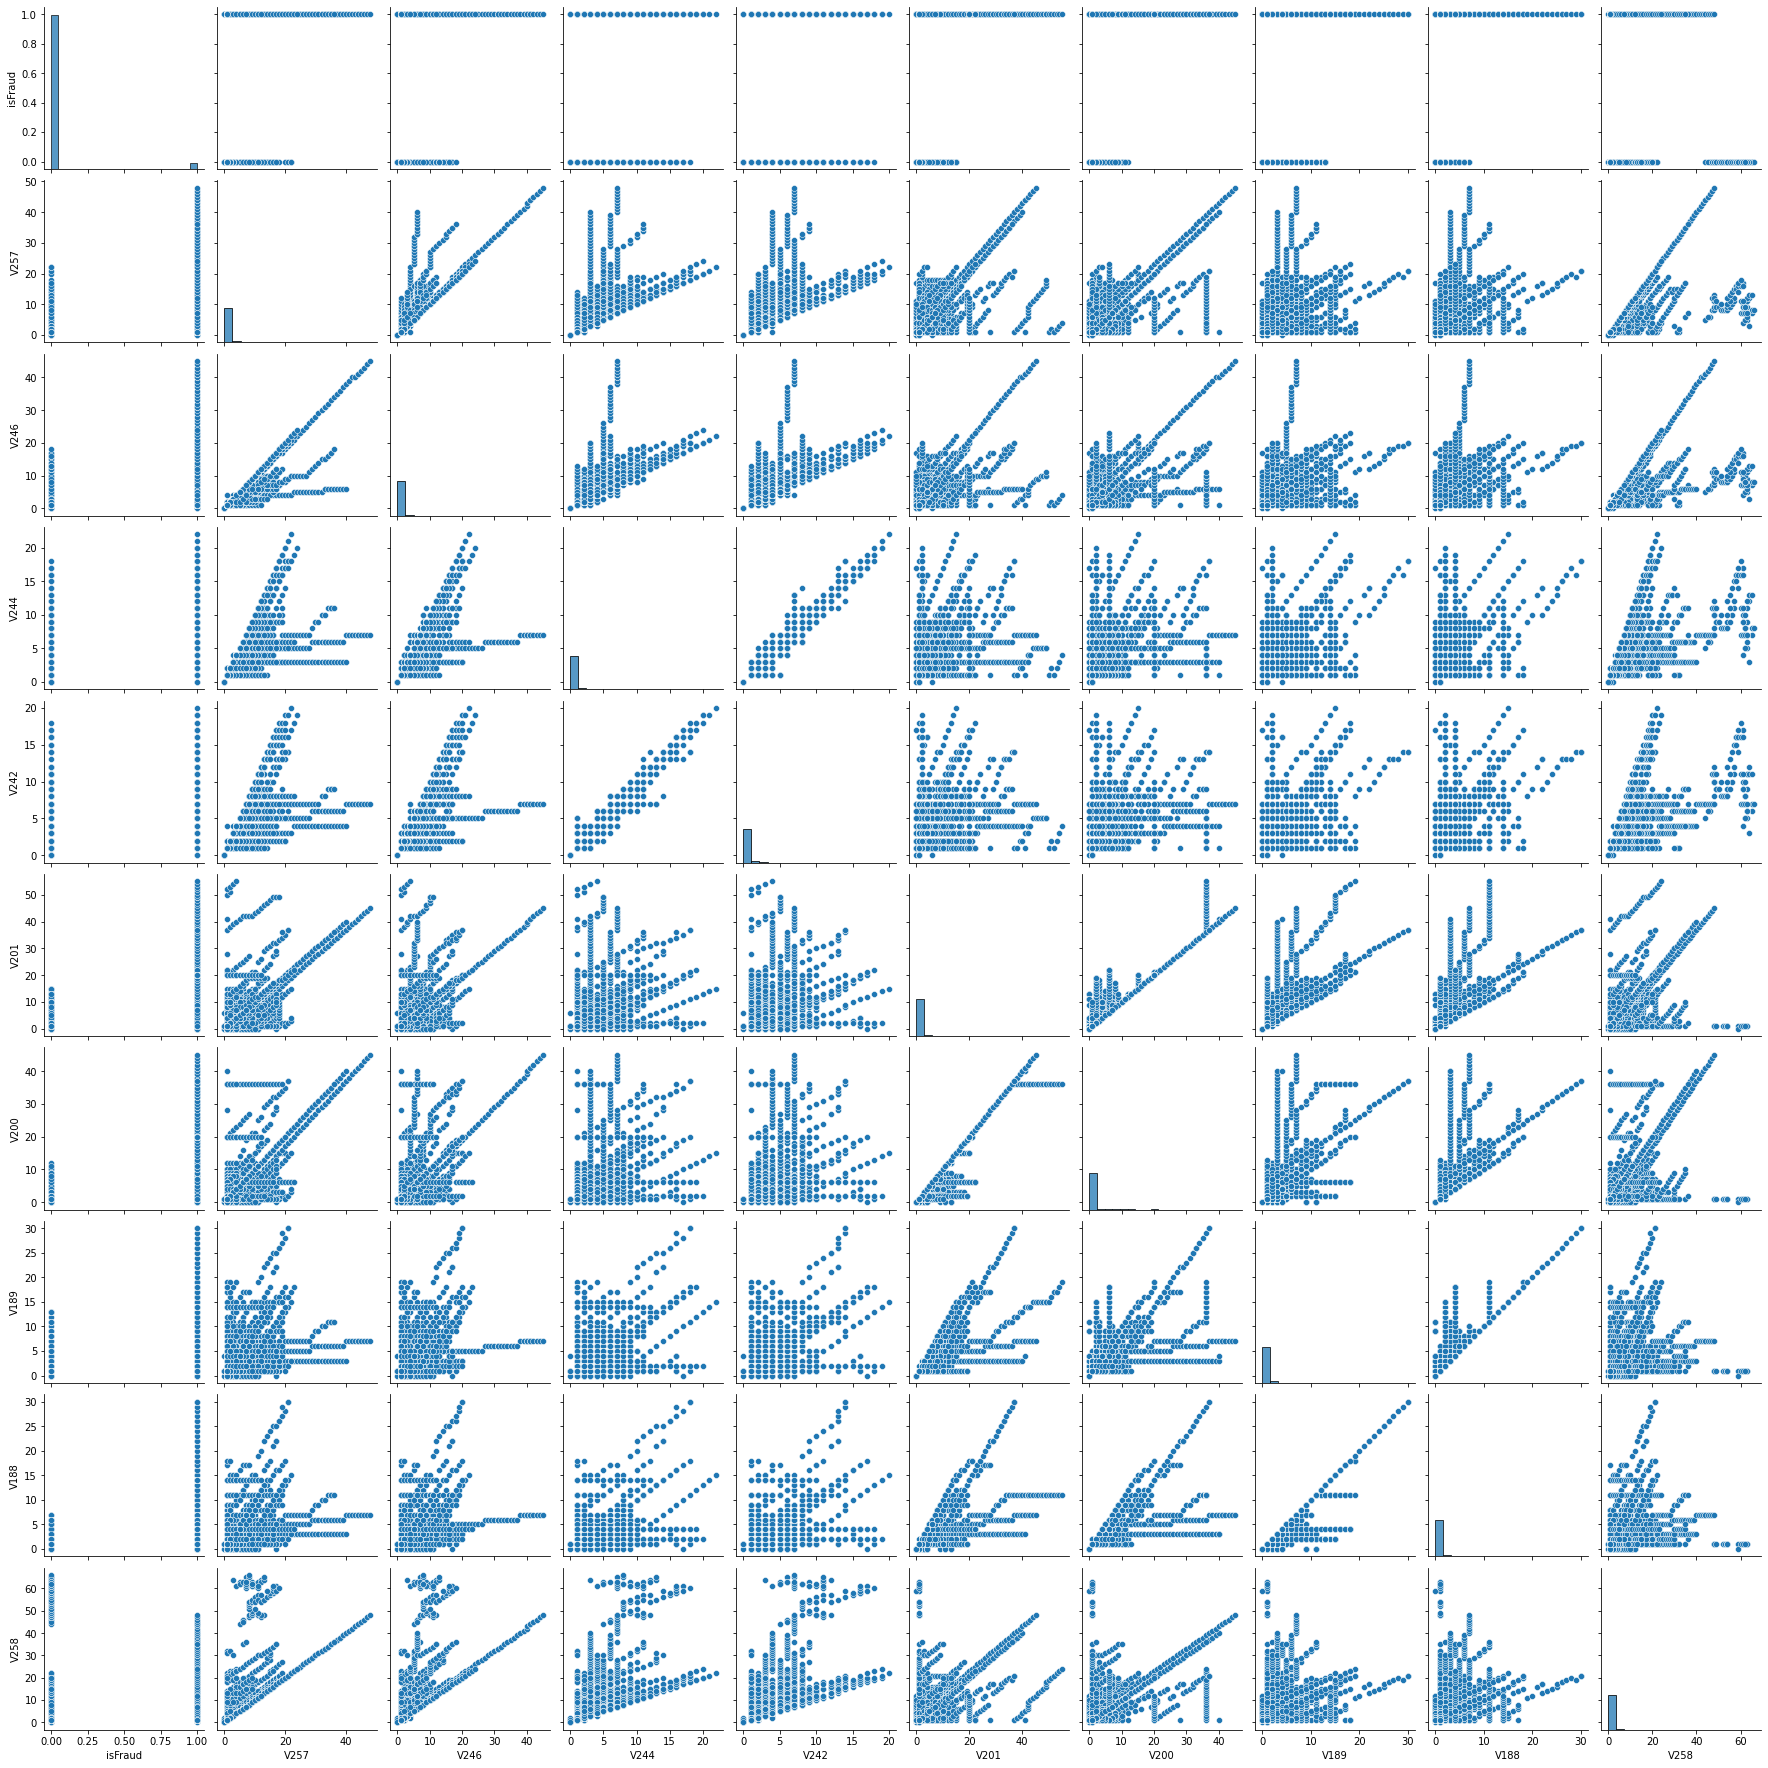

In [27]:
sns.pairplot(data[top_corr.index])

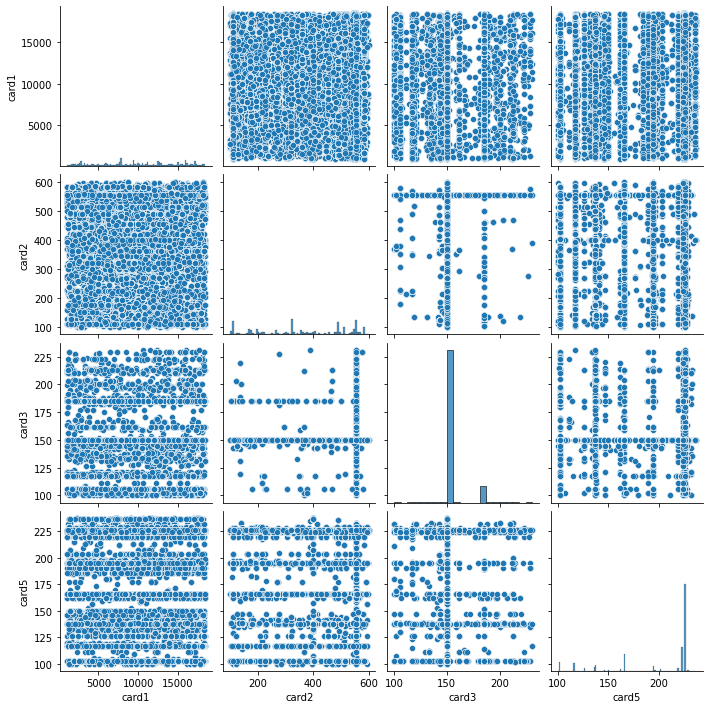

In [28]:
sns.pairplot(data[['card1','card2','card3','card4','card5','card6']])

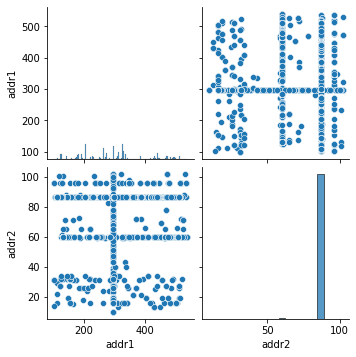

In [29]:
sns.pairplot(data[['addr1','addr2']])

In [30]:
P_email_df = pd.DataFrame(data.P_emaildomain.value_counts())
P_email_df = P_email_df.rename_axis("email").reset_index()
P_email_df = P_email_df[P_email_df["P_emaildomain"] > 1000]
Pemail_df = data[data["P_emaildomain"].isin(list(P_email_df["email"]))]

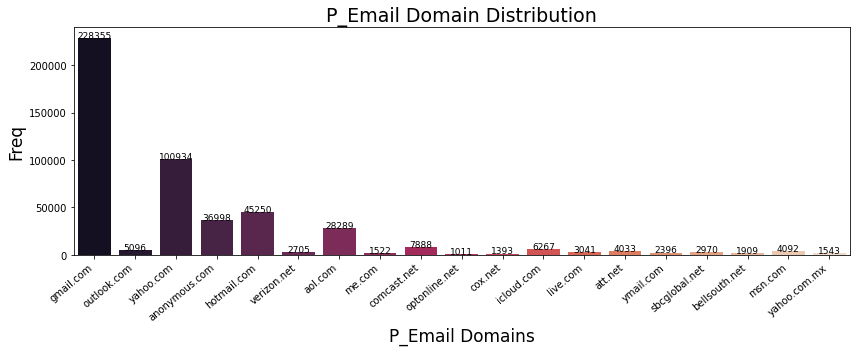

In [31]:
countplot_viz(
    data=Pemail_df,
    xcolumn="P_emaildomain",
    xlabel="P_Email Domains",
    ylabel="Freq",
    title="P_Email Domain Distribution",
    palette="rocket",
    fontsize_text=9,
)

In [32]:
 data.ProductCD.value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

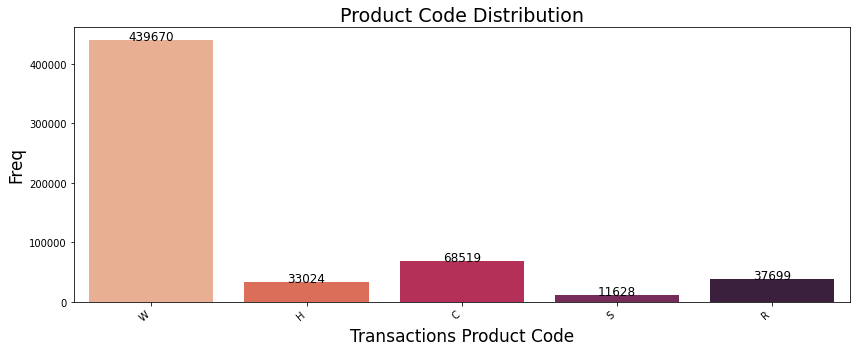

In [33]:
countplot_viz(data,"ProductCD","Transactions Product Code","Freq","Product Code Distribution",palette="rocket_r",)

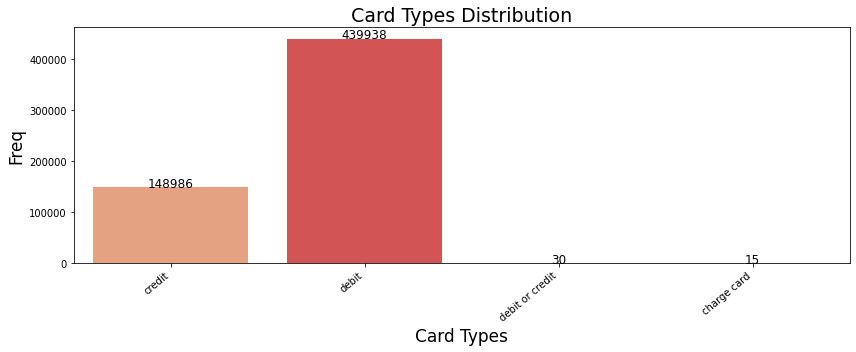

In [34]:
countplot_viz(data,"card6","Card Types","Freq","Card Types Distribution",palette="rocket_r",)

R_emaildomain shows recipient email domain. Certain transactions don't need recipient, so R_emaildomain is null.

In [35]:
R_email_df = pd.DataFrame(data.R_emaildomain.value_counts())
R_email_df = R_email_df.rename_axis("email").reset_index()
R_email_df = R_email_df[R_email_df["R_emaildomain"] > 1000]
Remail_df = data[data["R_emaildomain"].isin(list(R_email_df["email"]))]

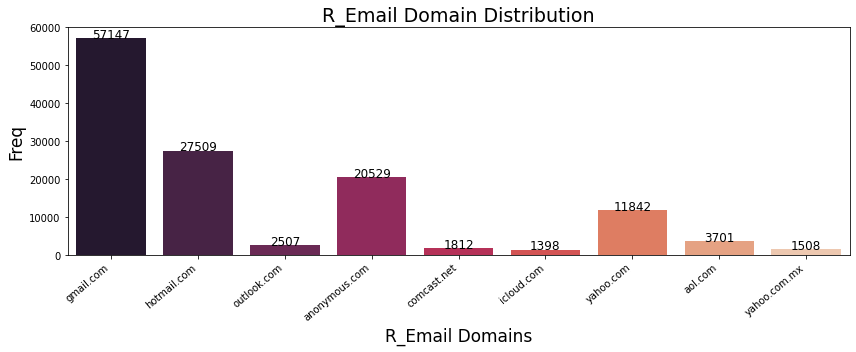

In [36]:
countplot_viz(data=Remail_df,xcolumn="R_emaildomain",xlabel="R_Email Domains",ylabel="Freq",title="R_Email Domain Distribution",palette="rocket",)

In [37]:
data["isFraud_"] = np.where(data["isFraud"] == 1, "Fraud", "Non-Fraud")

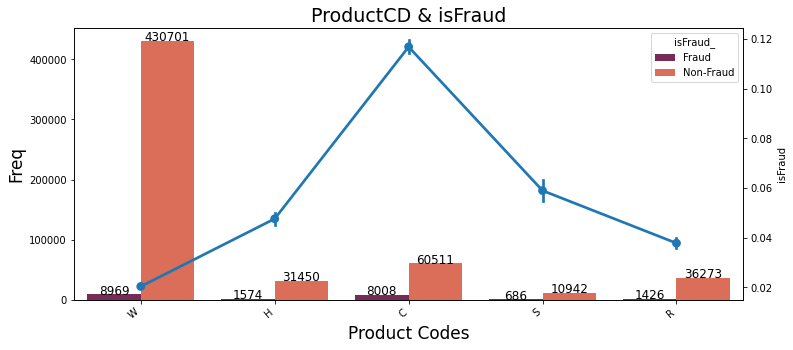

In [38]:
filter_list = ["Fraud", "Non-Fraud"]
countplot_pointplot_viz(data,filter_list,"ProductCD","isFraud_","isFraud","Product Codes","Freq","ProductCD & isFraud",palette="rocket",)

In [39]:
pd.crosstab(data.isFraud_, data.card4, margins=True).style.background_gradient(cmap="mako")

card4,american express,discover,mastercard,visa,All
isFraud_,,,,,
Fraud,239,514,6496,13373,20622
Non-Fraud,8089,6137,182721,371394,568341
All,8328,6651,189217,384767,588963


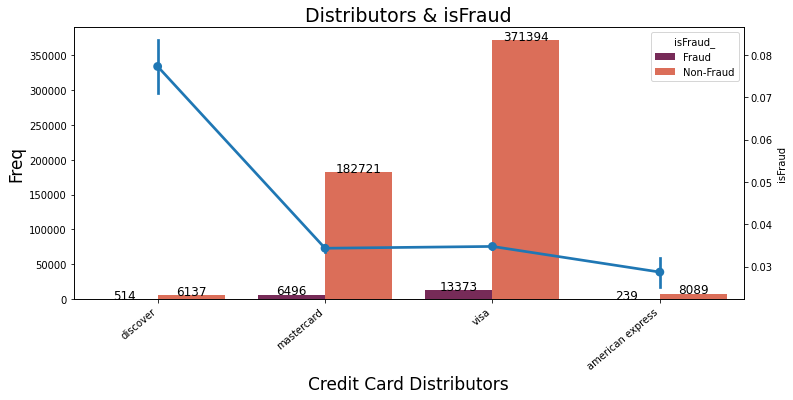

In [40]:
filter_list = ["Fraud", "Non-Fraud"]
countplot_pointplot_viz(data,filter_list,"card4","isFraud_","isFraud","Credit Card Distributors","Freq","Distributors & isFraud",palette="rocket",)

The most of transactions were done with "visa". 
The second most of transactions were done with "mastercard". Because of the fraudulent transaction counts of these distributors are higher than others. But we should look that how much fraud there is in all transaction of these distributors. (as rate)

* In total transactions of visa, fraudulent transactions' percentage is 0,034.
* In total transactions of mastercard, fraudulent transactions' percentage is 0,034.
* In total transactions of discovery, fraudulent transactions' percentage is 0,077.
* In total transactions of american express, fraudulent transactions' percentage is 0,028.

Due to above results we can say that "discover" is more open to fraudulent activities than other distributors.

In [41]:
pd.crosstab(data.isFraud_, data.card6, margins=True).style.background_gradient(cmap="mako")

card6,charge card,credit,debit,debit or credit,All
isFraud_,,,,,
Fraud,0,9950,10674,0,20624
Non-Fraud,15,139036,429264,30,568345
All,15,148986,439938,30,588969


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


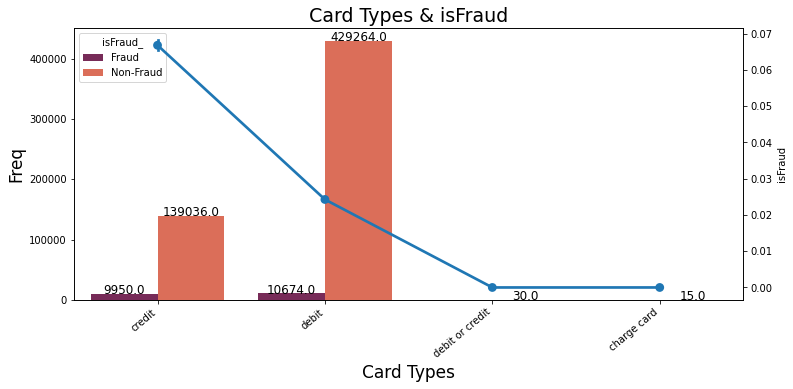

In [42]:
filter_list = ["Fraud", "Non-Fraud"]
countplot_pointplot_viz(data,filter_list,"card6","isFraud_","isFraud","Card Types","Freq","Card Types & isFraud",palette="rocket",)

Most of the transactions were done with "debit". The second most of the transactions were done with "credit card".

In total transactions of credit card, fraudulent transactions' rate is 0,066%. This rate is highest rate in all card types. Due to that result we can say that "credit card" is more open to fraudulent activities than other distributors.

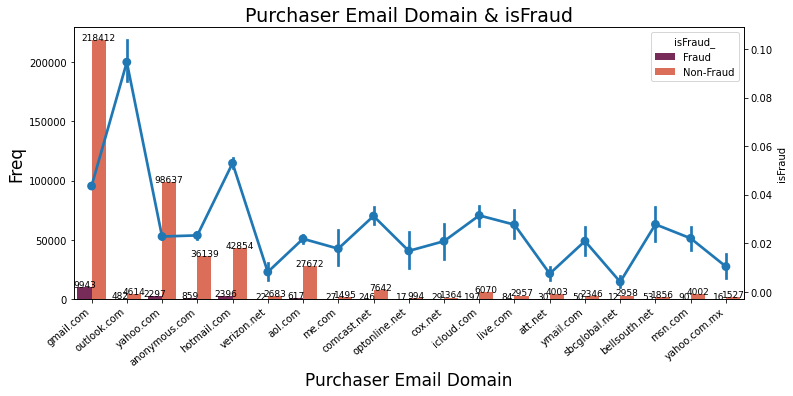

In [43]:
filter_list = ["Fraud", "Non-Fraud"]
P_email_df = pd.DataFrame(data.P_emaildomain.value_counts())
P_email_df = P_email_df.rename_axis("email").reset_index()
P_email_df = P_email_df[P_email_df["P_emaildomain"] > 1000]
Pemail_df = data[data["P_emaildomain"].isin(list(P_email_df["email"]))]

countplot_pointplot_viz(Pemail_df,filter_list,"P_emaildomain","isFraud_","isFraud","Purchaser Email Domain","Freq","Purchaser Email Domain & isFraud",fontsize_text=9,palette="rocket",)

The most of transactions belong to "gmail.com".

From the point of view of fraud transaction rate "outlook.com" has the highest fraudulent activities.

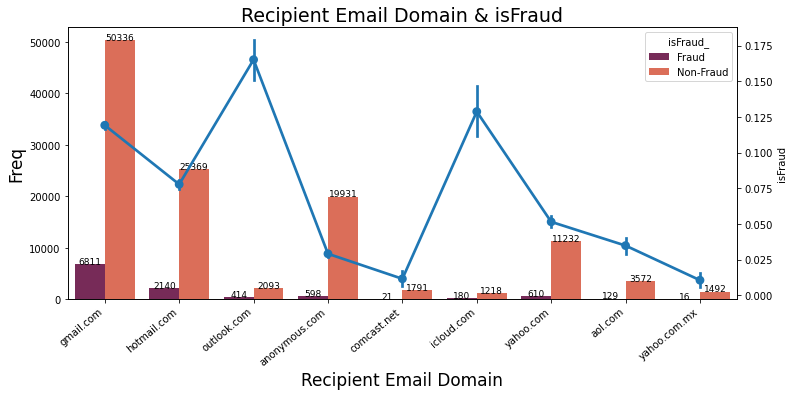

In [44]:
filter_list = ["Fraud", "Non-Fraud"]
R_email_df = pd.DataFrame(data.R_emaildomain.value_counts())
R_email_df = R_email_df.rename_axis("email").reset_index()
R_email_df = R_email_df[R_email_df["R_emaildomain"] > 1000]
Remail_df = data[data["R_emaildomain"].isin(list(R_email_df["email"]))]
countplot_pointplot_viz(Remail_df,filter_list,"R_emaildomain","isFraud_","isFraud","Recipient Email Domain","Freq","Recipient Email Domain & isFraud",fontsize_text=9,palette="rocket",)

Most of the transactions belong to "gmail.com".

From the point of view of fraud transaction rate "outlook.com" and "icloud.com" have the highest fraudulent activities.

In [45]:
data.drop(columns=['isFraud_'], inplace=True)

# Data transformation

In [46]:
start_mem = data.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

Memory usage of dataframe is 1959.88 MB



### Reduce data type sizes

In [47]:
reduced_float = 0
reduced_int = 0
for col in data.columns:
    if data[col].dtype == 'float64': 
      data[col] = data[col].astype('float32')
      reduced_float += 1
    elif data[col].dtype == 'int64': 
      data[col] = data[col].astype('int32')
      reduced_int += 1

print(f"Reduced {reduced_float} float columns")
print(f"Reduced {reduced_int} int columns")

Reduced 400 float columns
Reduced 4 int columns


In [48]:
start_mem = data.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

Memory usage of dataframe is 1049.77 MB


### Convert float typed columns to int types where possible

In [49]:
converted_float_to_int = 0
for col in data.select_dtypes(include='float32').columns:
  all_int_values = (data[col] % 1 == 0).all()
  if all_int_values:
    data[col] = data[col].astype('int32')
    converted_float_to_int += 1

print(f"Converted {converted_float_to_int} float columns to int columns")

Converted 14 float columns to int columns


In [50]:
start_mem = data.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

Memory usage of dataframe is 1049.77 MB


### Reduce int column size, based on max value

In [51]:
reduced_int_sizes = 0
for col in data.select_dtypes(include='int32').columns:
  if data[col].max() < 128: 
    data[col] = data[col].astype('int8')
    reduced_int_sizes += 1
  elif data[col].max() < 32768: 
    data[col] = data[col].astype('int16')
    reduced_int_sizes += 1

print(f"Reduced {reduced_int_sizes} int columns to smaller int size")

Reduced 16 int columns to smaller int size


In [52]:
start_mem = data.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

Memory usage of dataframe is 1030.62 MB


### Filling NaN values with the smallest value

In [53]:
for col in data.columns:
  if data[col].dtype != 'object': 
    min_col_value = data[col].min()
    data[col].fillna(min_col_value - 1, inplace=True)

# Feature engineering

### Exclude card2+, addr2, DeviceInfo, Transaction ID columns, as they are redundant

In [54]:
redundant_card_columns = [f'card{i}' for i in range(2, 7)]

redundant_cols = [*redundant_card_columns, 'addr2', 'DeviceInfo', 'TransactionID_x', 'TransactionID_y']

data.drop(columns=redundant_cols, inplace=True)

### Combine card1, addr1, email domain columns

In [55]:
colums_to_combine = ['card1', 'addr1', 'P_emaildomain']

comb_column_name = '_'.join(colums_to_combine)
data[comb_column_name] = functools.reduce(lambda x, y: x + '_' + y, [data[col].astype(str) for col in colums_to_combine])
data.drop(columns=colums_to_combine, inplace=True)

### Categorical features review

In [56]:
for col in data.select_dtypes(include='object').columns:
  values = data[col].unique()
  print(f'col {col} :: len {len(values)} :: values: {values}')

col ProductCD :: len 5 :: values: ['W' 'H' 'C' 'S' 'R']
col R_emaildomain :: len 61 :: values: [nan 'gmail.com' 'hotmail.com' 'outlook.com' 'anonymous.com' 'charter.net'
 'prodigy.net.mx' 'comcast.net' 'live.com.mx' 'icloud.com' 'yahoo.com'
 'aol.com' 'juno.com' 'att.net' 'verizon.net' 'yahoo.com.mx'
 'bellsouth.net' 'servicios-ta.com' 'ymail.com' 'hotmail.es' 'msn.com'
 'optonline.net' 'live.com' 'gmx.de' 'aim.com' 'mail.com' 'me.com'
 'outlook.es' 'cox.net' 'earthlink.net' 'embarqmail.com' 'web.de'
 'sbcglobal.net' 'scranton.edu' 'mac.com' 'twc.com' 'roadrunner.com'
 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'frontiernet.net' 'gmail' 'live.fr'
 'q.com' 'yahoo.co.uk' 'windstream.net' 'suddenlink.net' 'hotmail.fr'
 'ptd.net' 'hotmail.de' 'frontier.com' 'cfl.rr.com' 'hotmail.co.uk'
 'netzero.com' 'netzero.net' 'yahoo.co.jp' 'rocketmail.com'
 'centurylink.net' 'protonmail.com' 'cableone.net' 'sc.rr.com']
col M1 :: len 3 :: values: ['T' nan 'F']
col M2 :: len 3 :: values: ['T' nan 'F']
col M3 :: l

### Screen resolution feature encoding

In [57]:
hd_scrn_length = 1280
fullhd_scrn_length = 1920
twoK_scrn_length = 2560
fourK_scrn_length = 3840

def encodeScreenResolution(scrn_r):
  if type(scrn_r) != str or 'x' not in scrn_r:
    return -1
  scrn_length_part = scrn_r.split('x')[0]
  if not scrn_length_part.isdigit():
    return -1
  
  scrn_length = int(scrn_length_part)
  if scrn_length <= hd_scrn_length:
    return 1
  elif scrn_length <= fullhd_scrn_length:
    return 2
  elif scrn_length <= twoK_scrn_length:
    return 3
  elif scrn_length <= fourK_scrn_length:
    return 4
  else:
    return 5

In [58]:
scrn_resolution_column = 'id_33'
data['screen_resolution_n'] = data[scrn_resolution_column].apply(encodeScreenResolution).astype('int8')
data.drop(columns=[scrn_resolution_column], inplace=True)

### Add OS versions release dates dataset

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
os_dates = pd.read_csv('./drive/MyDrive/Colab Notebooks/OS_versions.csv', names=["OS", "OS_release_date"])
os_dates.describe()

,OS,OS_release_date
count,68,68
unique,68,59
top,Windows 10,15.05.2017
freq,1,2


In [61]:
os_dates['OS_release_date'] = os_dates['OS_release_date'].apply(lambda date: pd.to_datetime(date, format='%d.%m.%Y').value / 100000000000).astype('int32')
os_dates['OS_release_date'].unique()

array([14691456, 15107904, 14688000, 14381280, 14891040, 13480128,
       15505344, 15094080, 15063840, 14109120, 12482208, 13775616,
       14766624, 14743296, 14394240, 14633568, 14720832, 14295744,
       14718240, 14327712, 14911776, 13824000, 15101856, 11701152,
       14948064, 15069888, 14435712, 15032736, 14815008, 14851296,
       15057792, 14134176, 15062976, 13789440, 14745888, 14062464,
       10039680, 15121728, 12514176, 13437792, 13087872, 14585184,
       14772672, 14778720, 14531616, 14905728, 15125184, 13831776,
       14816736, 14157504, 15166656, 15131232, 15153696, 15222816,
       15189984, 15278112, 15275520, 15245280, 15310944], dtype=int32)

In [62]:
data = data.merge(os_dates, how="left", left_on='id_30', right_on='OS')
data['OS_release_date'] = data['OS_release_date'].fillna(0).astype('int32')
data['OS_release_date']

0         14691456
1         15107904
2                0
3                0
4         14688000
            ...   
590535           0
590536           0
590537           0
590538           0
590539           0
Name: OS_release_date, Length: 590540, dtype: int32

In [63]:
data['id_30'].astype('string')

0              Android 7.0
1               iOS 11.1.2
2                     <NA>
3                     <NA>
4         Mac OS X 10_11_6
                ...       
590535                <NA>
590536                <NA>
590537                <NA>
590538                <NA>
590539                <NA>
Name: id_30, Length: 590540, dtype: string

In [64]:
def remove_os_version(os):
  if type(os) is not str:
    return "Other"

  if "Mac OS X" in os:
    return "Mac OS X"
  if "Windows" in os:
    return "Windows"
  if "Android" in os:
    return "Android"
  if "iOS" in os:
    return "iOS"

  return "Other"


data['id_30'] = data['id_30'].apply(remove_os_version)

### Categorical data encoding

In [65]:
cat_columns = data.select_dtypes(include='object').columns

for col in cat_columns:
  col_unique_values = data[col].unique()
  value_index_dict = dict((v, i) for i, v in enumerate(col_unique_values))

  col_type = 'int32'
  if len(col_unique_values) < 128: 
    col_type = 'int8'
  elif len(col_unique_values) < 32768: 
    col_type = 'int16'

  data[f'{col}_n'] = data[col].apply(lambda x: value_index_dict[x]).astype(col_type)

data.drop(columns=cat_columns, inplace=True)

### Remove strongly correlated features

In [66]:
corr_matrix = data.corr().abs()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [67]:
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]

data.drop(columns=to_drop, inplace=True)

In [68]:
to_drop

['C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D2',
 'D12',
 'D15',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V36',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V96',
 'V97',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V1

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   isFraud                      590540 non-null  int8   
 1   TransactionDT                590540 non-null  int32  
 2   TransactionAmt               590540 non-null  float32
 3   dist1                        590540 non-null  float32
 4   dist2                        590540 non-null  float32
 5   C1                           590540 non-null  int16  
 6   C3                           590540 non-null  int8   
 7   C5                           590540 non-null  int16  
 8   D1                           590540 non-null  float32
 9   D3                           590540 non-null  float32
 10  D4                           590540 non-null  float32
 11  D5                           590540 non-null  float32
 12  D6                           590540 non-null  float32
 13 

# Train/test split

0    427408
1     15497
Name: isFraud, dtype: int64

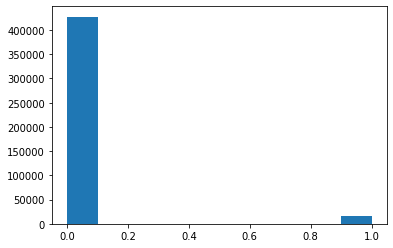

In [70]:
from sklearn.model_selection import train_test_split

target = 'isFraud'

x_all_data = data.drop(columns=[target])
y_all_data = data[target]

x_train, x_test, y_train, y_test = train_test_split(x_all_data, y_all_data, random_state=3, stratify=y_all_data, shuffle=True)

plt.hist(y_train)
y_train.value_counts()

### Oversample data

In [71]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
x_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    427408
0    427408
dtype: int64

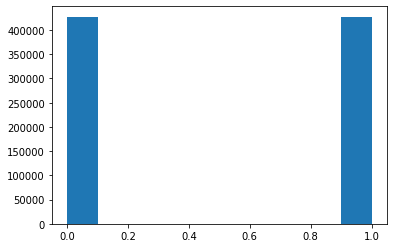

In [72]:
plt.hist(y_train_oversampled)
pd.Series(y_train_oversampled).value_counts()

### Undersample data

In [73]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')
x_train_undersampled, y_train_undersampled = undersample.fit_resample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    15497
0    15497
dtype: int64

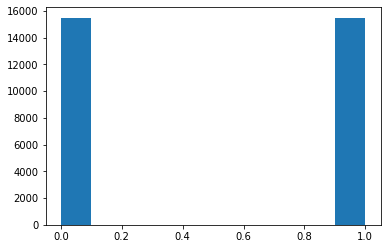

In [74]:
plt.hist(y_train_undersampled)
pd.Series(y_train_undersampled).value_counts()

# Model design

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import lightgbm as lgb

In [76]:
def validate_results(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  print('Confustion matrix')
  print(metrics.confusion_matrix(y_test, y_pred))
  print('Recall score')
  print(metrics.recall_score(y_test, y_pred))
  print('ROC AUC score')
  print(metrics.roc_auc_score(y_test, y_pred))

### Random forest

In [77]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state=1)
rf_model.fit(x_train_oversampled, y_train_oversampled)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [78]:
rf_y_pred = rf_model.predict(x_test)
validate_results(y_test, rf_y_pred)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142469
           1       0.88      0.47      0.61      5166

    accuracy                           0.98    147635
   macro avg       0.93      0.73      0.80    147635
weighted avg       0.98      0.98      0.98    147635

Confustion matrix
[[142147    322]
 [  2750   2416]]
Recall score
0.46767324816105305
ROC AUC score
0.7327065536792462


## LGBM

In [ ]:
def lgbm(X_train, Y_train, X_test, Y_test, is_balanced, lgbm_params = {}):
  x_lgbm_train, x_valid, y_lgbm_train, y_valid = train_test_split(X_train, Y_train, random_state=0, stratify=Y_train, shuffle=True)

  lgbm_train_data = lgb.Dataset(x_lgbm_train, label=y_lgbm_train)
  lgbm_valid_data = lgb.Dataset(x_valid, label=y_valid)

  parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true' if is_balanced else 'false',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
  }

  parameters = {**parameters, **lgbm_params}

  print(f'Using params: {parameters}')

  lgbm_model = lgb.train(parameters,
                        lgbm_train_data,
                        valid_sets=lgbm_valid_data,
                        num_boost_round=5000,
                        early_stopping_rounds=100)
  
  lgbm_y_pred = lgbm_model.predict(x_test)

  for threshold in [0.5, 0.6, 0.7]:
    print(f'\nThreshold = {threshold}')
    rounded_y_pred = [1 if pred > threshold else 0 for pred in lgbm_y_pred]
    validate_results(y_test, rounded_y_pred)

  return lgbm_model

### LGBM with imbalanced data

In [ ]:
imbalanced_lgbm_model = lgbm(x_train, y_train, x_test, y_test, False)

Using params: {'application': 'binary', 'objective': 'binary', 'metric': 'auc', 'is_unbalance': 'false', 'boosting': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 20, 'learning_rate': 0.05, 'verbose': 0}
[1]	valid_0's auc: 0.776162
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.809419
[3]	valid_0's auc: 0.818038
[4]	valid_0's auc: 0.832476
[5]	valid_0's auc: 0.835379
[6]	valid_0's auc: 0.837531
[7]	valid_0's auc: 0.839344
[8]	valid_0's auc: 0.84191
[9]	valid_0's auc: 0.844923
[10]	valid_0's auc: 0.846854
[11]	valid_0's auc: 0.848212
[12]	valid_0's auc: 0.850467
[13]	valid_0's auc: 0.85238
[14]	valid_0's auc: 0.853416
[15]	valid_0's auc: 0.854198
[16]	valid_0's auc: 0.854719
[17]	valid_0's auc: 0.85586
[18]	valid_0's auc: 0.856621
[19]	valid_0's auc: 0.856814
[20]	valid_0's auc: 0.857398
[21]	valid_0's auc: 0.858092
[22]	valid_0's auc: 0.858913
[23]	valid_0's auc: 0.860608
[24]	valid_0's auc: 0.861031
[25

### LGBM with oversampled data

In [ ]:
oversampled_lgbm_model = lgbm(x_train_oversampled, y_train_oversampled, x_test, y_test, True)

Streaming output truncated to the last 5000 lines.
[57]	valid_0's auc: 0.880877
[58]	valid_0's auc: 0.881155
[59]	valid_0's auc: 0.881433
[60]	valid_0's auc: 0.881963
[61]	valid_0's auc: 0.882347
[62]	valid_0's auc: 0.882821
[63]	valid_0's auc: 0.883241
[64]	valid_0's auc: 0.88362
[65]	valid_0's auc: 0.884039
[66]	valid_0's auc: 0.884385
[67]	valid_0's auc: 0.884737
[68]	valid_0's auc: 0.885298
[69]	valid_0's auc: 0.885629
[70]	valid_0's auc: 0.885996
[71]	valid_0's auc: 0.886284
[72]	valid_0's auc: 0.886626
[73]	valid_0's auc: 0.886885
[74]	valid_0's auc: 0.887231
[75]	valid_0's auc: 0.887575
[76]	valid_0's auc: 0.887961
[77]	valid_0's auc: 0.888291
[78]	valid_0's auc: 0.888643
[79]	valid_0's auc: 0.889083
[80]	valid_0's auc: 0.889411
[81]	valid_0's auc: 0.889655
[82]	valid_0's auc: 0.890008
[83]	valid_0's auc: 0.8903
[84]	valid_0's auc: 0.890535
[85]	valid_0's auc: 0.890908
[86]	valid_0's auc: 0.891171
[87]	valid_0's auc: 0.891473
[88]	valid_0's auc: 0.891733
[89]	valid_0's auc: 0.89

### LGBM with undersampled data

In [ ]:
underampled_lgbm_model = lgbm(x_train_undersampled, y_train_undersampled, x_test, y_test, True)

Using params: {'application': 'binary', 'objective': 'binary', 'metric': 'auc', 'is_unbalance': 'true', 'boosting': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 20, 'learning_rate': 0.05, 'verbose': 0}
[1]	valid_0's auc: 0.807996
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.825291
[3]	valid_0's auc: 0.834396
[4]	valid_0's auc: 0.839669
[5]	valid_0's auc: 0.844364
[6]	valid_0's auc: 0.846825
[7]	valid_0's auc: 0.848388
[8]	valid_0's auc: 0.850672
[9]	valid_0's auc: 0.851323
[10]	valid_0's auc: 0.852499
[11]	valid_0's auc: 0.854013
[12]	valid_0's auc: 0.85372
[13]	valid_0's auc: 0.85369
[14]	valid_0's auc: 0.854441
[15]	valid_0's auc: 0.854996
[16]	valid_0's auc: 0.855409
[17]	valid_0's auc: 0.85676
[18]	valid_0's auc: 0.857692
[19]	valid_0's auc: 0.858391
[20]	valid_0's auc: 0.858738
[21]	valid_0's auc: 0.859859
[22]	valid_0's auc: 0.860136
[23]	valid_0's auc: 0.860644
[24]	valid_0's auc: 0.861146
[25]

## Grid Search based on LGBM (using oversampled data)

### Define LGBM classifier

In [ ]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          metric = 'auc',
          feature_fraction = 0.5,
          bagging_fraction = 0.5,
          bagging_freq = 20,
          silent = True,
          learning_rate = 0.05,
          num_leaves = 31)

# To view the default model parameters:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'metric', 'feature_fraction', 'bagging_fraction', 'bagging_freq'])

### Run Grid search

In [ ]:
gridParams = {
    'learning_rate': [0.01, 0.05],
    'n_estimators': [20, 50, 100],
    'num_leaves': [20, 30, 40, 60],
    'max_depth': [5, 7, 10],
    'min_data_in_leaf': [20, 50],
    'boosting_type' : ['gbdt', 'dart'], 
    'objective' : ['binary'],
    'max_bin': [255, 510],
    'random_state' : [500]
    }

grid = GridSearchCV(mdl, gridParams, verbose=2, cv=3, n_jobs=-1, scoring='roc_auc')

grid.fit(x_train_oversampled, y_train_oversampled)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 91.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 158.5min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 270.0min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 344.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.5, bagging_freq=20,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.5,
                                      importance_type='split',
                                      learning_rate=0.05, max_depth=-1,
                                      metric='auc', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,...
             iid='deprecated', n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05], 'max_bin': [255, 510],
                         'max_depth': [5, 7, 10], 'min_data_in_leaf': [20, 50],
             

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_bin': 510, 'max_depth': 10, 'min_data_in_leaf': 50, 'n_estimators': 100, 'num_leaves': 60, 'objective': 'binary', 'random_state': 500}
0.9141223918571567


### Train LGBM with best GS params

In [ ]:
gs_lgbm_model = lgbm(x_train_oversampled, y_train_oversampled, x_test, y_test, True, {**grid.best_params_, 'num_boost_round': 5000})

Using params: {'application': 'binary', 'objective': 'binary', 'metric': 'auc', 'is_unbalance': 'true', 'boosting': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 20, 'learning_rate': 0.05, 'verbose': 0, 'boosting_type': 'gbdt', 'max_bin': 510, 'max_depth': 10, 'min_data_in_leaf': 50, 'n_estimators': 100, 'random_state': 500, 'num_boost_round': 5000}


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Streaming output truncated to the last 5000 lines.
[57]	valid_0's auc: 0.895562
[58]	valid_0's auc: 0.896038
[59]	valid_0's auc: 0.896615
[60]	valid_0's auc: 0.896918
[61]	valid_0's auc: 0.897231
[62]	valid_0's auc: 0.897695
[63]	valid_0's auc: 0.898131
[64]	valid_0's auc: 0.898544
[65]	valid_0's auc: 0.899081
[66]	valid_0's auc: 0.899491
[67]	valid_0's auc: 0.899798
[68]	valid_0's auc: 0.900165
[69]	valid_0's auc: 0.900707
[70]	valid_0's auc: 0.901043
[71]	valid_0's auc: 0.901698
[72]	valid_0's auc: 0.902243
[73]	valid_0's auc: 0.902748
[74]	valid_0's auc: 0.903182
[75]	valid_0's auc: 0.903831
[76]	valid_0's auc: 0.904186
[77]	valid_0's auc: 0.904591
[78]	valid_0's auc: 0.905029
[79]	valid_0's auc: 0.905423
[80]	valid_0's auc: 0.905832
[81]	valid_0's auc: 0.906461
[82]	valid_0's auc: 0.906726
[83]	valid_0's auc: 0.907092
[84]	valid_0's auc: 0.907337
[85]	valid_0's auc: 0.907737
[86]	valid_0's auc: 0.908298
[87]	valid_0's auc: 0.908647
[88]	valid_0's auc: 0.90887
[89]	valid_0's auc: 0.

In [ ]:
gs_lgbm_model.save_model('final_lgbm_model.txt')

In [ ]:
lgbm_y_pred = gs_lgbm_model.predict(x_test)


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    142469
           1       0.57      0.74      0.64      5166

    accuracy                           0.97    147635
   macro avg       0.78      0.86      0.81    147635
weighted avg       0.98      0.97      0.97    147635

Confustion matrix
[[139594   2875]
 [  1368   3798]]
Recall score
0.735191637630662
ROC AUC score
0.8575059045181856

Threshold = 0.45
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    142469
           1       0.62      0.72      0.67      5166

    accuracy                           0.98    147635
   macro avg       0.81      0.85      0.83    147635
weighted avg       0.98      0.98      0.98    147635

Confustion matrix
[[140234   2235]
 [  1442   3724]]
Recall score
0.7208672086720868
ROC AUC score
0.8525897926998278

Threshold = 0.5
              precision    recall  f1-score   support

    

# Model evaluation results

In [ ]:
model_scores = pd.DataFrame()

thresholds = [n / 100 for n in range(20, 82, 2)]

In [ ]:
model_scores['x_thresholds'] = pd.Series(thresholds)

model_scores['rounded_predictions'] = model_scores['x_thresholds'].apply(lambda t: [1 if pred > t else 0 for pred in lgbm_y_pred])

model_scores['y_recall'] = model_scores['rounded_predictions'].apply(lambda p: metrics.recall_score(y_test, p))
model_scores['y_precision'] = model_scores['rounded_predictions'].apply(lambda p: metrics.precision_score(y_test, p))

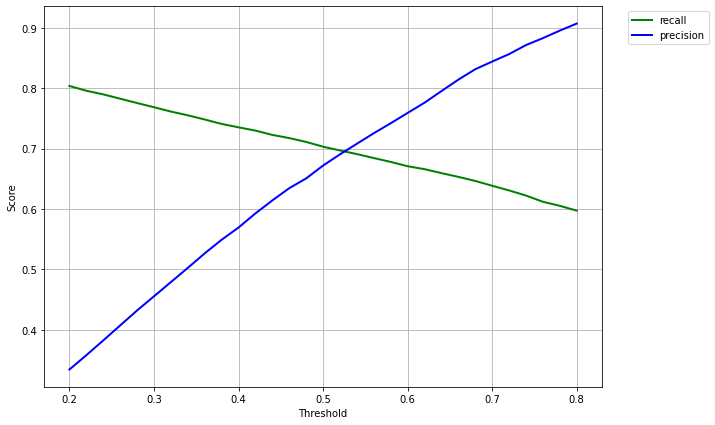

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(model_scores['x_thresholds'], model_scores['y_recall'], linewidth=2, color='green')
plt.plot(model_scores['x_thresholds'], model_scores['y_precision'], linewidth=2, color='blue')
plt.legend(['recall', 'precision'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid()
plt.show()